In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from scipy.optimize import minimize_scalar

matplotlib.use('Agg')

matplotlib.style.use('default')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 9.0
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage[detect-all,locale=DE]{siunitx}')

%matplotlib inline

In [2]:
adjoint = False
if adjoint:
    adjoint_s = '_adjoint'
else:
    adjoint_s = ''

# Load constants

In [3]:
nu_Sigma_fc_1 = 0.008476  # cm^-1
nu_Sigma_fc_2 = 0.18514
# Sigma_fc_1 = 0.003320
# Sigma_fc_2 = 0.07537
Sigma_ac_1 = 0.01207
Sigma_ac_2 = Sigma_rc_2 = 0.1210
Dc_1 = 1.2627  # cm
Dc_2 = 0.3543
Sigma_rc_1 = 0.02619
Sigma_sc_12 = Sigma_rc_1 - Sigma_ac_1

Dr_1 = 1.13
Dr_2 = 0.16
Sigma_rr_1 = 0.0494
Sigma_ar_1 = 0.0004
Sigma_ar_2 = 0.0197
Sigma_sr_12 = Sigma_rr_1 - Sigma_ar_1

# Define matrix

In [4]:
k_eff = 1

In [5]:
if adjoint:
    Am = np.array([[(nu_Sigma_fc_1 / k_eff - Sigma_rc_1) / Dc_1, Sigma_sc_12 / Dc_1], 
                   [nu_Sigma_fc_2 / k_eff / Dc_2, -Sigma_ac_2 / Dc_2]])
else:
    Am = np.array([[(nu_Sigma_fc_1 / k_eff - Sigma_rc_1) / Dc_1, nu_Sigma_fc_2 / k_eff / Dc_1], 
                   [Sigma_sc_12 / Dc_2, -Sigma_ac_2 / Dc_2]])

In [6]:
L2 = Dc_2 / Sigma_ac_2
tau = Dc_1 / (Sigma_rc_1 - nu_Sigma_fc_1 / k_eff)
k_p = (nu_Sigma_fc_1 + nu_Sigma_fc_2 * Sigma_sc_12 / Sigma_ac_2) / Sigma_rc_1
delta = (k_p - nu_Sigma_fc_1 / Sigma_rc_1) / (k_eff - nu_Sigma_fc_1 / Sigma_rc_1)

In [7]:
harm_Lt = 1 / L2 + 1 / tau
mu2 = 0.5 * (-(harm_Lt) + np.sqrt(harm_Lt ** 2 + 4 * (delta - 1) / tau / L2))
mu = np.sqrt(mu2)
nu2 = 0.5 * ((harm_Lt) + np.sqrt(harm_Lt ** 2 + 4 * (delta - 1) / tau / L2))
nu = np.sqrt(nu2)

In [8]:
if adjoint:
    s1 = nu_Sigma_fc_2 / k_eff / Dc_2 / (mu2 + 1 / L2)
    s2 = nu_Sigma_fc_2 / k_eff / Dc_2 / (1 / L2 - nu2)
else:
    s1 = Sigma_sc_12 / Dc_2 / (mu2 + 1 / L2)
    s2 = Sigma_sc_12 / Dc_2 / (1 / L2 - nu2)

alpha = 1 / np.sqrt(1 + s1 ** 2)
beta = 1 / np.sqrt(1 + s2 ** 2)

u1 = np.array([alpha, alpha * s1])
u2 = np.array([beta, beta * s2])

U = np.array([u1, u2]).T

inv_U = np.linalg.inv(U)

In [9]:
mu2_p = Sigma_rr_1 / Dr_1
nu2_p = Sigma_ar_2 / Dr_2
mu_p = np.sqrt(mu2_p)
nu_p = np.sqrt(nu2_p)

if adjoint:
    ga2_p = Sigma_sr_12 / Dr_1
    c_p = ga2_p / (mu2_p - nu2_p)
else:
    ga2_p = Sigma_sr_12 / Dr_2
    c_p = ga2_p / (nu2_p - mu2_p)

# Fit $r_0$

In [10]:
def M(r):
    hr = r / 2
    if adjoint:
        M = np.array([[alpha * np.cos(mu * hr), beta * (np.exp(-nu * hr) + np.exp(nu * hr)), 
                       -np.exp(-mu_p * hr), -c_p * np.exp(-nu_p * hr)], 
                      [s1 * alpha * np.cos(mu * hr), s2 * beta * (np.exp(-nu * hr) + np.exp(nu * hr)), 
                       0, -np.exp(-nu_p * hr)], 
                      [-Dc_1 * mu * alpha * np.sin(mu * hr), Dc_1 * beta * (-nu * np.exp(-nu * hr) + nu * np.exp(nu * hr)), 
                       Dr_1 * mu_p * np.exp(-mu_p * hr), Dr_1 * nu_p * c_p * np.exp(-nu_p * hr)], 
                      [-Dc_2 * mu * s1 * alpha * np.sin(mu * hr), Dc_2 * s2 * beta * (-nu * np.exp(-nu * hr) + nu * np.exp(nu * hr)), 
                       0, Dr_2 * nu_p * np.exp(-nu_p * hr)]])
    else:
        M = np.array([[alpha * np.cos(mu * hr), beta * (np.exp(-nu * hr) + np.exp(nu * hr)), 
                       -np.exp(-mu_p * hr), 0], 
                      [s1 * alpha * np.cos(mu * hr), s2 * beta * (np.exp(-nu * hr) + np.exp(nu * hr)), 
                       -c_p * np.exp(-mu_p * hr), -np.exp(-nu_p * hr)], 
                      [-Dc_1 * mu * alpha * np.sin(mu * hr), Dc_1 * beta * (-nu * np.exp(-nu * hr) + nu * np.exp(nu * hr)), 
                       Dr_1 * mu_p * np.exp(-mu_p * hr), 0], 
                      [-Dc_2 * mu * s1 * alpha * np.sin(mu * hr), Dc_2 * s2 * beta * (-nu * np.exp(-nu * hr) + nu * np.exp(nu * hr)), 
                       Dr_2 * mu_p * c_p * np.exp(-mu_p * hr), Dr_2 * nu_p * np.exp(-nu_p * hr)]])
    return M

def det_M(r):
    return np.linalg.det(M(r))

# Solve linear equations

In [11]:
rst = minimize_scalar(lambda x: np.abs(det_M(x)), bounds=(20, 80), method='bounded')
# rst = minimize_scalar(lambda x: np.abs(det_M(x)), bounds=(150, 170), method='bounded')

r0 = rst.x
print(f'L0 is {r0:.3f}cm')
M0 = M(r0)

A = 1

B, A_p, B_p = A * np.linalg.inv(M0[1:, 1:]).dot(-M0[1:, 0])

L0 is 38.715cm


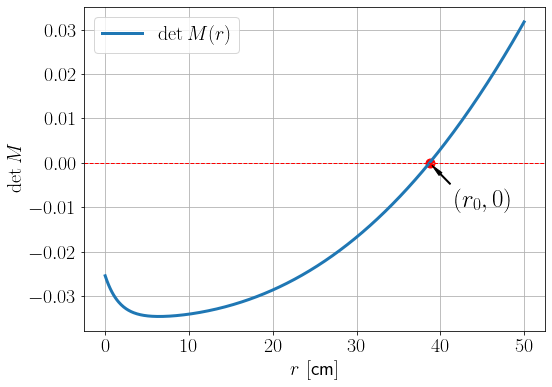

In [12]:
fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])

r = np.linspace(0, 50, 501)
if adjoint:
    label=r'$\det M^*(r)$'
else:
    label=r'$\det M(r)$'
ax.plot(r, np.vectorize(det_M)(r), lw=3., label=label)
ax.axhline(0, color='r', linestyle='dashed', lw='1.')
ax.scatter(r0, det_M(r0), color='r')
ax.annotate(text=r'$(r_0,0)$', xy=(r0, det_M(r0)), xytext=(r0 + 3, -0.01), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=1., headwidth=4.), fontsize=25)
ax.set_xlabel(r'$r\ [\si{cm}]$')
if adjoint:
    ax.set_ylabel(r'$\det M^*$')
else:
    ax.set_ylabel(r'$\det M$')
# ax.set_xlim(60, 150)
# ax.set_ylim()
# ax.set_yscale('log')
ax.grid()
ax.legend(prop={'size': 20})

# fig.savefig(f'thesis/figures/det_M_r{adjoint_s}.svg', transparent=True, dpi=800)

plt.show()

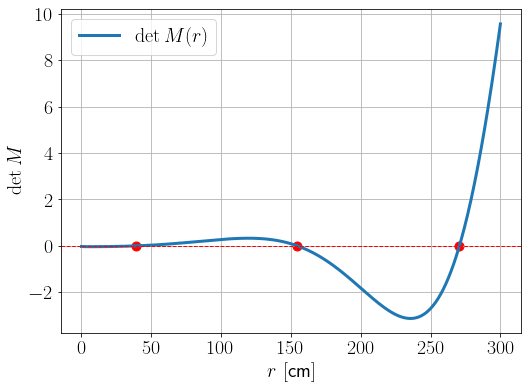

In [13]:
if not adjoint:
    fig = plt.figure(figsize=(8, 6))
    # fig.tight_layout()
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
    ax = fig.add_subplot(gs[0, 0])

    r = np.linspace(0, 300, 501)
    ax.plot(r, np.vectorize(det_M)(r), lw=3., label=r'$\det M(r)$')
    ax.axhline(0, color='r', linestyle='dashed', lw='1.')
    rst0 = minimize_scalar(lambda x: np.abs(det_M(x)), bounds=(20, 80), method='bounded')
    rst1 = minimize_scalar(lambda x: np.abs(det_M(x)), bounds=(150, 170), method='bounded')
    rst2 = minimize_scalar(lambda x: np.abs(det_M(x)), bounds=(250, 300), method='bounded')
    ax.scatter(rst0.x, det_M(rst0.x), color='r')
    ax.scatter(rst1.x, det_M(rst1.x), color='r')
    ax.scatter(rst2.x, det_M(rst2.x), color='r')
    ax.set_xlabel(r'$r\ [\si{cm}]$')
    ax.set_ylabel(r'$\det M$')
    # ax.set_xlim(60, 150)
    # ax.set_ylim()
    # ax.set_yscale('log')
    ax.grid()
    ax.legend(prop={'size': 20})

    fig.savefig('thesis/figures/det_M_r_far.svg', transparent=True, dpi=800)

    plt.show()

In [14]:
def varphi_1(x):
    return A * np.cos(mu * x)

def varphi_2(x):
    return B * (np.exp(-nu * x) + np.exp(nu * x))

def phi_12(x):
    return U.dot(np.array([varphi_1(x), varphi_2(x)]))

def phi_12_p(x):
    if adjoint:
        varphi_1_p = A_p * np.exp(-mu_p * x) + c_p * B_p * np.exp(-nu_p * x)
        varphi_2_p = B_p * np.exp(-nu_p * x)
    else:
        varphi_1_p = A_p * np.exp(-mu_p * x)
        varphi_2_p = c_p * A_p * np.exp(-mu_p * x) + B_p * np.exp(-nu_p * x)
    return np.array([varphi_1_p, varphi_2_p])

def phi_1(x):
    return np.where(x < r0 / 2, phi_12(x)[0], phi_12_p(x)[0])

def phi_2(x):
    return np.where(x < r0 / 2, phi_12(x)[1], phi_12_p(x)[1])

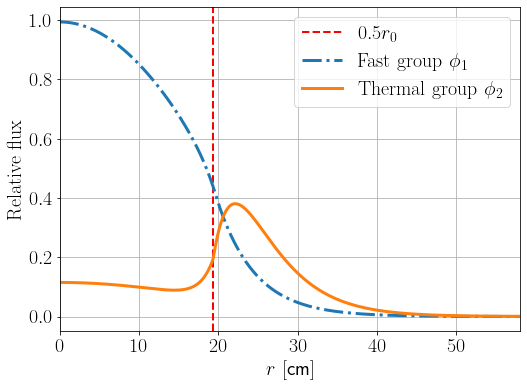

In [15]:
fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])

r = np.linspace(0, r0 * 1.5, 501)
ax.axvline(r0 / 2, color='r', linestyle='dashed', label=r'$0.5 r_0$')
if adjoint:
    ax.plot(r, np.vectorize(phi_1)(r), '-.', lw=3., label=r'$\mathrm{Fast\ group}\ \phi_1^*$')
    ax.plot(r, np.vectorize(phi_2)(r), '-', lw=3., label=r'$\mathrm{Thermal\ group}\ \phi_2^*$')
else:
    ax.plot(r, np.vectorize(phi_1)(r), '-.', lw=3., label=r'$\mathrm{Fast\ group}\ \phi_1$')
    ax.plot(r, np.vectorize(phi_2)(r), '-', lw=3., label=r'$\mathrm{Thermal\ group}\ \phi_2$')
# ax.axhline(0, color='r')
ax.set_xlabel(r'$r\ [\si{cm}]$')
ax.set_ylabel(r'$\mathrm{Relative\ flux}$')
ax.set_xlim(r[0], r[-1])
# ax.set_ylim()
# ax.set_yscale('log')
ax.grid()
ax.legend(loc='upper right', prop={'size': 20})

# fig.savefig(f'thesis/figures/flux_r{adjoint_s}.svg', transparent=True, dpi=800)

plt.show()